In [1]:
# Headers

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import healpy as hp

from astropy.io import fits
from astropy.table import Table, Column

import treecorr

# Input Cl's

In [2]:
def read_cl():
    l = np.loadtxt('../data/Cell_data-f1z1f1z1.dat', usecols=(0))
    l = np.append(np.array([0.0,1.0]), l[:8191])
    cl = np.loadtxt('../data/Cell_data-f1z1f1z1.dat', usecols=(1))
    cl = np.append(np.array([0.0,0.0]), cl[:8191])
    return l, cl

l , cl = read_cl()

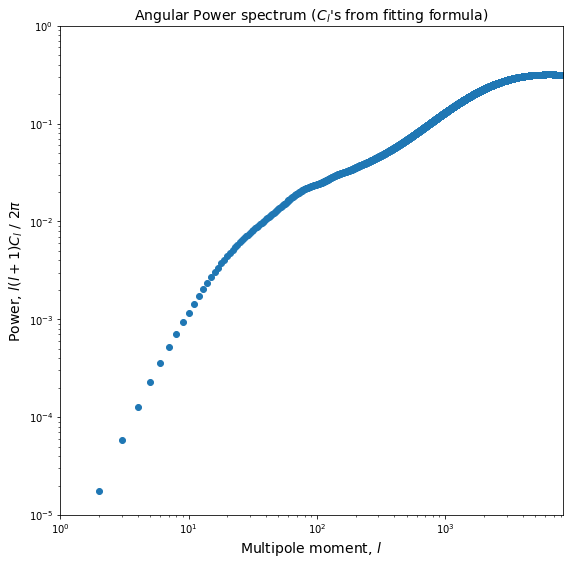

In [3]:
plt.figure(figsize=(9,9))

plt.scatter(l, l*(l+1)*cl/(2*np.pi))
plt.yscale('log')
plt.xscale('log')
plt.xlim(1,8192)
plt.ylim(1e-5,1)
plt.xlabel('Multipole moment, $l$', fontsize=14)
plt.ylabel('Power, $l(l+1)C_l$ / $2π$', fontsize=14)
plt.title('Angular Power spectrum ($C_l$\'s from fitting formula)', fontsize=14)
plt.savefig('./simulations_output/plot_output/Angular_power_spectrum_Cl_data.pdf')

# Healpy (for visualisation and creating map)

In [4]:
# can also be done just by reading the normal txt file instead of the fits file

nside = 4096

#density_field_gaussian = hp.synfast(cl, nside)
#hp.write_map("./simulations_output/gaussian_map/gaussian_map.fits", density_field_gaussian)

In [5]:
density_field_gaussian = hp.fitsfunc.read_map('./simulations_output/gaussian_map/gaussian_map.fits')

#plt.figure(figsize=(12,12))
#hp.mollview(density_field_gaussian, min=-1, max=4)
#hp.graticule()
#plt.savefig('./simulations_output/plot_output/density_field_gaussian_map.pdf')

NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


# Make a single patch of pixels and save with astropy (fits) for feeding into treecorr

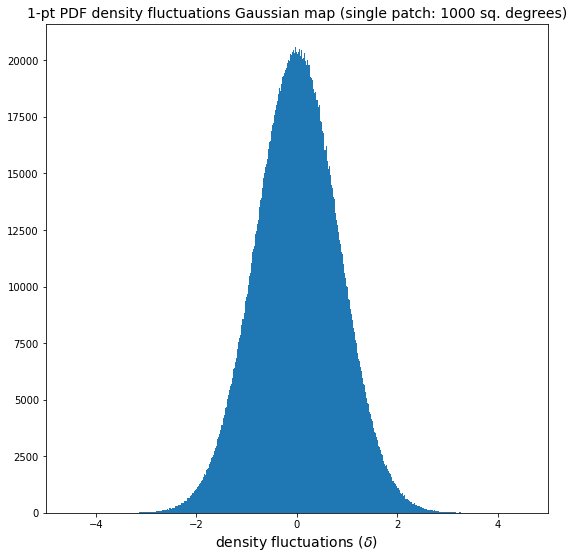

In [6]:
# Choose a random pixel i.e. center of disc (patch on the sky map) around which to take 1000 deg square area
disc_center = hp.pix2vec(nside, 101010101)

# radius (in radians) corresponding to 1000 deg square patch in sky = 0.31 radians

# find the pixels 
pixels_indices_disc = hp.query_disc(nside, disc_center, 0.31)

density_field_gaussian_disc = density_field_gaussian[pixels_indices_disc]
dec = np.pi/2 - hp.pix2ang(nside, pixels_indices_disc)[0]
RA = hp.pix2ang(nside, pixels_indices_disc)[1]

# for saving into fits file with astropy
RA_data = Column(RA, name='RA', dtype='float') # column having ra
dec_data = Column(dec, name='dec', dtype='float') # column having dec
del_data = Column(density_field_gaussian_disc, name='del', dtype='float') # column having pixels_disc_values

density_fluctuations_table = Table((RA_data, dec_data, del_data))  
# density_fluctuations_table.show_in_notebook()

density_fluctuations_table.write("./simulations_output/single_patch/density_fluctuations_gaussian_single_patch.fits" , overwrite=True)

# 1-pt PDF of density fluctuations within patch

plt.figure(figsize=(9,9))
plt.hist(density_field_gaussian_disc, bins=1000)
plt.xlabel('density fluctuations ($δ$)', fontsize=14)
plt.xlim(-5,5)
plt.title('1-pt PDF density fluctuations Gaussian map (single patch: 1000 sq. degrees)', fontsize=14)
plt.savefig("./simulations_output/plot_output/1_pt_PDF_single_patch/density_fluctuations_gaussian_1_pt_PDF_single_patch.pdf")

# TreeCorr: for autocorrelation of the Gaussian density fluctuations

In [7]:
density_fluctuations = hp.read_cl('./simulations_output/single_patch/density_fluctuations_gaussian_single_patch.fits')

density_fluctuations_RA = density_fluctuations[0,:]
density_fluctuations_dec = density_fluctuations[1,:]
density_fluctuations_del = density_fluctuations[2,:]

cat = treecorr.Catalog(ra=density_fluctuations_RA, dec=density_fluctuations_dec,
                       ra_units='rad', dec_units='rad', k=density_fluctuations_del)

kk = treecorr.KKCorrelation(min_sep=1, max_sep=300, nbins=20, sep_units='arcmin')
kk.process(cat) 
theta_tc = kk.rnom
w_tc = kk.xi

dat = np.array([theta_tc, w_tc])
dat = dat.T
np.savetxt('./simulations_output/single_patch/treecorr_angular_correlation_gaussian_single_patch.txt', dat, delimiter = ' ')

In [8]:
def w_theta(theta):
    x = np.cos(theta)
    coeff = (2*l+1)/(4*np.pi)*cl
    w = np.polynomial.legendre.legval(x, coeff)
    return w     

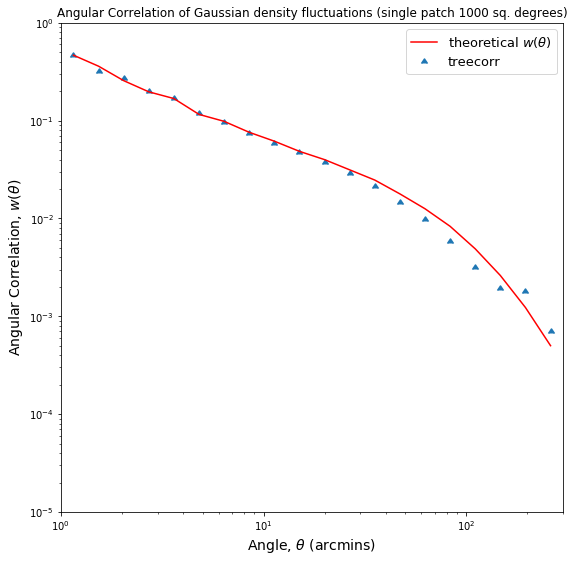

In [9]:
theta_treecorr = np.loadtxt('./simulations_output/single_patch/treecorr_angular_correlation_gaussian_single_patch.txt', usecols=(0)) # in arcmins
w_treecorr = np.loadtxt('./simulations_output/single_patch/treecorr_angular_correlation_gaussian_single_patch.txt', usecols=(1)) # w(theta)

plt.figure(figsize=(9,9))
plt.scatter(theta_treecorr,w_treecorr, marker=10, label='treecorr')
plt.plot(theta_treecorr, w_theta(theta_treecorr/60*np.pi/180), c='r', label='theoretical $w(θ)$')
plt.xlim(1,300)
plt.ylim(1e-5, 1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Angle, $θ$ (arcmins)', fontsize=14)
plt.ylabel('Angular Correlation, $w(θ)$', fontsize=14)
plt.title('Angular Correlation of Gaussian density fluctuations (single patch 1000 sq. degrees)')
plt.legend(fontsize=13)
plt.savefig('./simulations_output/plot_output/treecorr_and_theoretical_angular_correlation_gaussian_single_patch.pdf')